# DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project


In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

#### Gather data, determine the method of data collection and provenance of the data (3 points)

The data used for this project is a collection of houses/apartments for rent in AirBnB available obtained from [kaggle.com](https://www.kaggle.com). It was collected from Google Websites through web scrapping, you can find more [here](https://www.kaggle.com/datasets/paramvir705/airbnb-data/data).

#### Identify an Unsupervised Learning Problem (6 points)

The focus of this work is to build an unsupervised learning model to predict AirBnB prices, the performance of this model will be compared to other supervised learning approaches as a benchmark to determine the viability of this method.

#### Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (26 points)

 Go through the initial data cleaning and EDA and judge whether you need to collect more or different data. 

In [71]:
raw_data = pd.read_csv('Airbnb_Data.csv')

In [72]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

Through a first glimpse of the data, some issues with null values were found. Variables with information about host, review and other were dropped, followed by a cleanse of any null values left. After these steps, a total of 66,919 observations will be of useful for the analysis.

In [73]:
cols = [i for i in raw_data.columns if not i.startswith('host') and 'review' not in i]
raw_data = raw_data[cols]
raw_data = raw_data.drop(['thumbnail_url', 'zipcode', 'instant_bookable', 'cancellation_policy', 'description', 'latitude', 'longitude', 'name'], axis=1)
raw_data = raw_data.dropna().copy()
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66919 entries, 0 to 74110
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             66919 non-null  int64  
 1   log_price      66919 non-null  float64
 2   property_type  66919 non-null  object 
 3   room_type      66919 non-null  object 
 4   amenities      66919 non-null  object 
 5   accommodates   66919 non-null  int64  
 6   bathrooms      66919 non-null  float64
 7   bed_type       66919 non-null  object 
 8   cleaning_fee   66919 non-null  bool   
 9   city           66919 non-null  object 
 10  neighbourhood  66919 non-null  object 
 11  bedrooms       66919 non-null  float64
 12  beds           66919 non-null  float64
dtypes: bool(1), float64(4), int64(2), object(6)
memory usage: 6.7+ MB


The data is then sampled to reduce the data processing durations.

In [74]:
sampled_data = raw_data.sample(n=10000, random_state=42)

The next step is to separate the data into training and testing sets. A 75-25 split was chose.

In [75]:
# Split the data into train/test sets
train_data, test_data = train_test_split(sampled_data, test_size=0.25, random_state=42)

# Print the shapes of the train/test sets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (7500, 13)
Test data shape: (2500, 13)


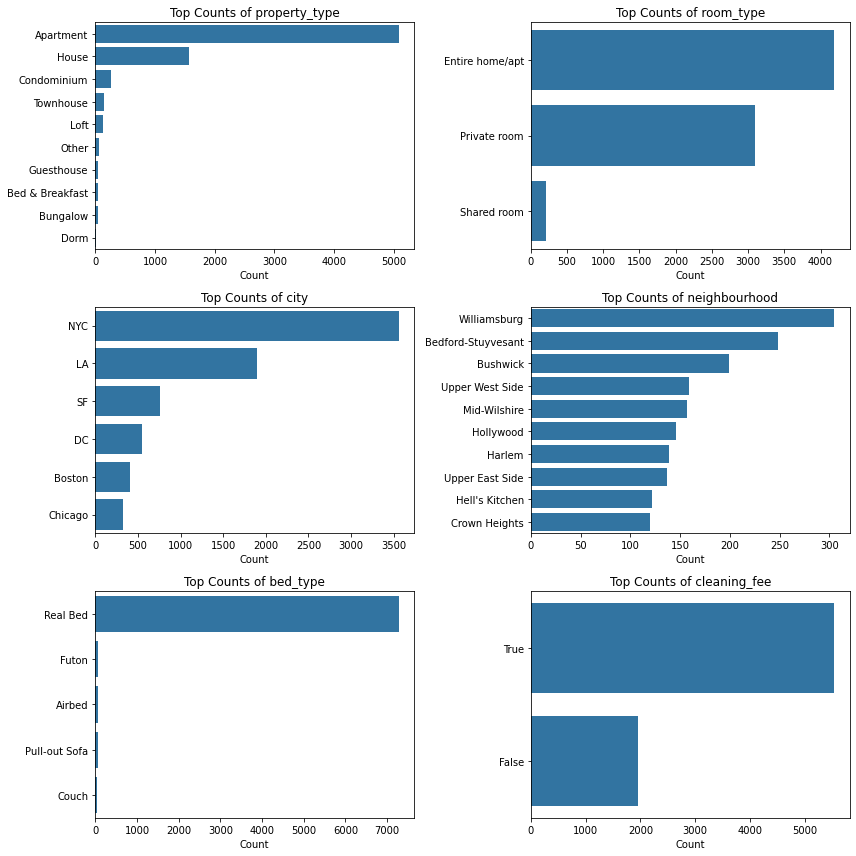

In [76]:
selected_columns = ['property_type', 'room_type', 'city', 'neighbourhood', 'bed_type', 'cleaning_fee']

fig, axes = plt.subplots(len(selected_columns)//2, 2, figsize=(12, 12))

for i, column in enumerate(selected_columns):
    row = i // 2
    col = i % 2
    sns.countplot(y=train_data[column], order=train_data[column].value_counts().nlargest(10).index, ax=axes[row, col])
    axes[row, col].set_title(f'Top Counts of {column}')
    axes[row, col].set_xlabel('Count')
    axes[row, col].set_ylabel('')

plt.tight_layout()
plt.show()


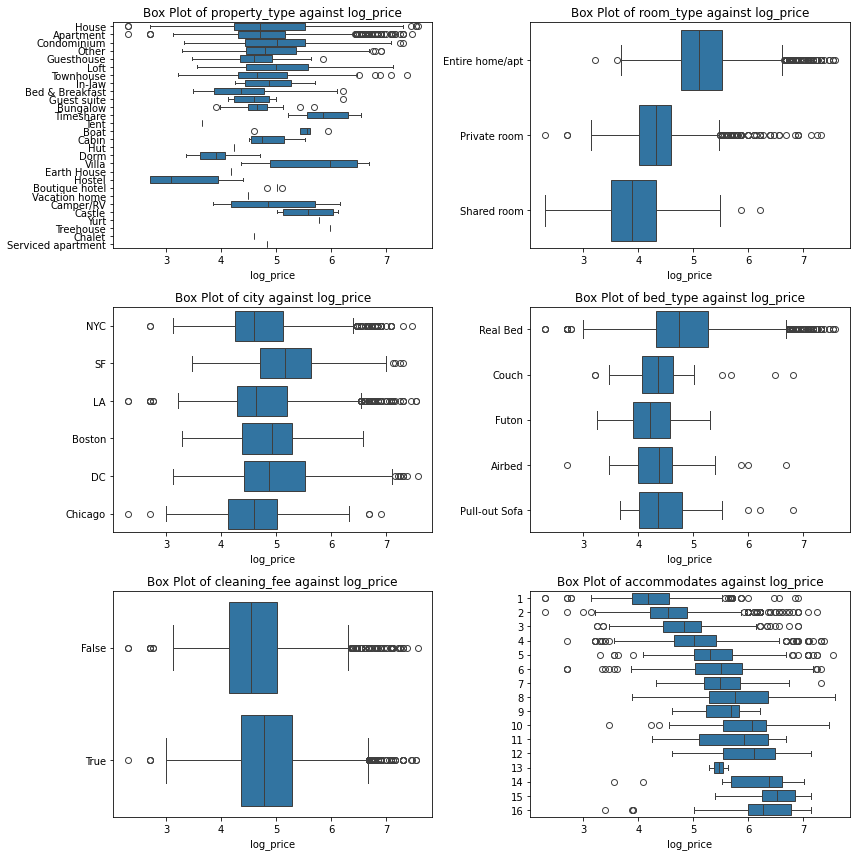

In [77]:
selected_columns = ['property_type', 'room_type', 'city', 'bed_type', 'cleaning_fee', 'accommodates']

fig, axes = plt.subplots(len(selected_columns)//2, 2, figsize=(12, 12))

for i, column in enumerate(selected_columns):
    row = i // 2
    col = i % 2
    sns.boxplot(y=train_data[column], x=train_data['log_price'], orient='h', ax=axes[row, col])
    axes[row, col].set_title(f'Box Plot of {column} against log_price')
    axes[row, col].set_xlabel('log_price')
    axes[row, col].set_ylabel('')

plt.tight_layout()
plt.show()

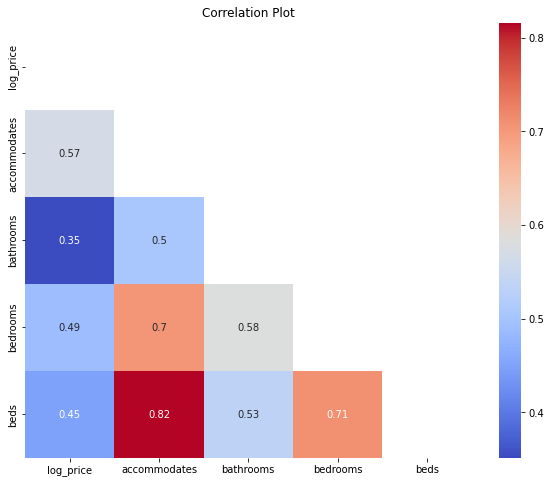

In [78]:
# Select the columns for correlation plot
selected_columns = ['log_price', 'accommodates', 'bathrooms', 'bedrooms', 'beds']

# Calculate the correlation matrix
correlation_matrix = train_data[selected_columns].corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Correlation Plot')
plt.show()

Transform the data

In [79]:
def preprocess_data(data):
    # Drop the 'log_price' column
    X = data.drop(['log_price', 'id'], axis=1)
    
    # Create a copy of the 'log_price' column
    y = data['log_price'].copy()
    
    # Create dummy variables for categorical columns
    X = X.join(X['amenities']
                   .str.strip('{}')
                   .str.get_dummies(',')
                   .rename(lambda x: x + '_amenities', axis=1))
    X = X.drop('amenities', axis=1)
    X['cleaning_fee'] = X['cleaning_fee']*1
    cols = ['property_type', 'room_type', 'city', 'neighbourhood', 'bed_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds']
    for col in cols:
        X = X.join(X[col]
                   .astype(str)
                   .str.get_dummies()
                   .rename(lambda x: x + '_' + col, axis=1))
        X = X.drop(col, axis=1)
        X = X.fillna(0)
    return X, y

#### Perform Analysis Using Unsupervised Learning Models of your Choice, Present Discussion, and Conclusions (70 points)

In [80]:
X_train, y_train = preprocess_data(train_data)

In [81]:
sparse_data = csr_matrix(X_train)

def jaccard_similarity_csr(csr_matrix):

    # Compute the intersection matrix
    intersection = csr_matrix.dot(csr_matrix.T)

    # Compute the union matrix
    # To calculate the union, we sum the binary matrix with its transpose
    union = csr_matrix.sum(axis=1) + csr_matrix.sum(axis=1).T - intersection

    # Calculate Jaccard similarity
    jaccard_similarity_matrix = intersection / union

    return np.array(jaccard_similarity_matrix)

# Calculate Jaccard similarity matrix
sim = jaccard_similarity_csr(sparse_data)
sim

array([[1.        , 0.30555556, 0.39130435, ..., 0.325     , 0.42857143,
        0.47368421],
       [0.30555556, 1.        , 0.34146341, ..., 0.33333333, 0.4137931 ,
        0.38235294],
       [0.39130435, 0.34146341, 1.        , ..., 0.32608696, 0.34883721,
        0.48837209],
       ...,
       [0.325     , 0.33333333, 0.32608696, ..., 1.        , 0.23684211,
        0.39473684],
       [0.42857143, 0.4137931 , 0.34883721, ..., 0.23684211, 1.        ,
        0.42857143],
       [0.47368421, 0.38235294, 0.48837209, ..., 0.39473684, 0.42857143,
        1.        ]])

In [82]:
yp = []
for i in range(len(sim)):
    yp.append(np.dot(sim[i,:], y_train) / np.sum(sim[i,:]))
yp = np.array(yp)

0.6868248739038435


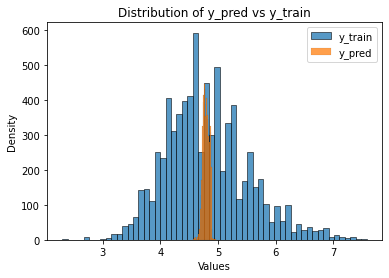

In [83]:
rmse = mean_squared_error(y_train, yp, squared=False)
print(rmse)
sns.histplot(y_train, label='y_train')
sns.histplot(yp, label='y_pred')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of y_pred vs y_train')
plt.legend()
plt.show()

# Discussion

The unsupervised learning approach performed very poorly, it doesn't seems to be much variation around the mean. A much simpler approach of just utilizing the average price by room_type might suffice to outperform this method. The only insight gained is the relevance of csr matrix operations for this kind of caculations because the jaccard_similarity function from scikit-learn is way too slow for 1000+ observations.

In [84]:
# Create a random forest regressor object
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

# Validate the model
y_pred = rf_model.predict(X_train)

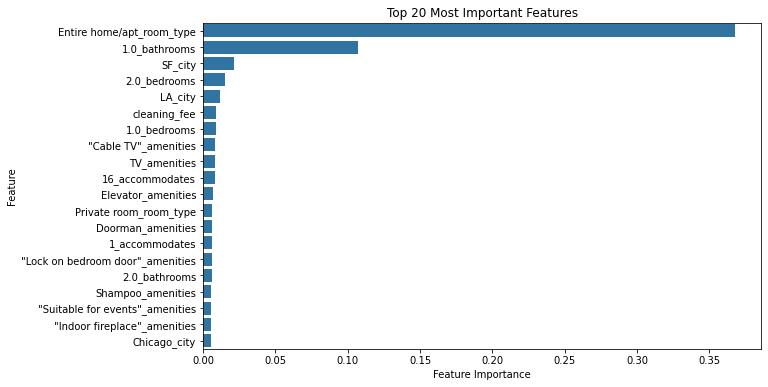

In [85]:
# Get feature importances
importances = rf_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select top 10 features
top_features = feature_names[indices][:20]
top_importances = importances[indices][:20]

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features')
plt.show()

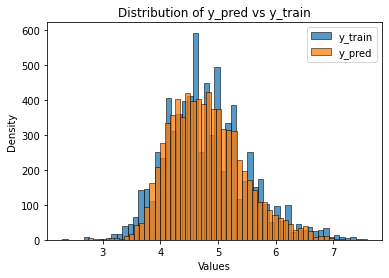

In [86]:
sns.histplot(y_train, label='y_train')
sns.histplot(y_pred, label='y_pred')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of y_pred vs y_train')
plt.legend()
plt.show()

In [87]:
mean_squared_error(y_pred, y_train)

0.027040282230051702

# Conclusion

The supervised learning approach, in this case a random forest, is exponetially better than the recommender system approach, at least for modeling house prices, it's also way more efficent on memory and training duration. Specifically, the random forest method since it is optimal for working with large amount of features (694 variables) which only took about 20 seconds to train and can easily visualize the most relevant features.

On the other hand, the recommender system approach is obviously very relevant for the customer looking for an AirBnB to stay at, it is just not a good way for the user intending to rent its place to benchmark prices.

Due to the terrible performance of the unsupervised learning approach, the analysis what left as is, without necessity to calculate the results for the testing data set. The main hypothesis was to tell if the recommender system could be match the performance of well known methods like random forest, and it showed mayor flaws by just attempting to predict the training set.

# References
- Dataset:
    - https://www.kaggle.com/datasets/paramvir705/airbnb-data/data
- Github repository: 
    - https://github.com/luisdi28ms/unsupervised-learning